In [3]:
#Get geometry of TiC with SIMAN
from siman.calc_manage import  get_structure_from_matproj, smart_structure_read # sudo pip3 install siman

TiC = get_structure_from_matproj(mat_proj_id = 'mp-631')#Get TiC structure from MaterialsProject database
TiC.printme()#show geometry of unit cell
TiC.write_poscar('sampleinputs/POSCAR_em')#Write geometry as POSCAR file


TiC = smart_structure_read('sampleinputs/POSCAR_em') #read POSCAR file with SIMAN


In [4]:
#Create conventional cell with SIMAN
TiC_conv = TiC.get_conventional_cell()
TiC_conv.printme()

Full Formula (Ti4 C4)
Reduced Formula: TiC
abc   :   4.335650   4.335650   4.335650
angles:  90.000000  90.000000  90.000000
Sites (8)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Ti    0    0    0
  1  Ti    0    0.5  0.5
  2  Ti    0.5  0    0.5
  3  Ti    0.5  0.5  0
  4  C     0.5  0    0
  5  C     0.5  0.5  0.5
  6  C     0    0    0.5
  7  C     0    0.5  0


In [5]:
#Energy minimization
# %matplotlib inline

from siman.classes import CalculationVasp 
cl = CalculationVasp(output='sampleoutputs/OUTCAR_em')
cl.read_results() #only one energy point due to initial structure was optimized

-- Attention!, SCF was not converged to desirable prec -0.018 > 0 meV 



'  -18.5239  |3.07, 3.07, 3.07|    208,208,208     |   1,12, 12   '

In [41]:
#Read elastic tensor with SIMAN
from siman.classes import CalculationVasp 
cl = CalculationVasp(output='sampleoutputs/OUTCAR_elastic')
cl.read_results()

-- Elastic tensor, GPa: 

[[ 541.3  133.8  133.8   -0.0    0.0    0.0]
 [ 133.8  541.3  133.8   -0.0    0.0    0.0]
 [ 133.8  133.8  541.3   -0.0    0.0    0.0]
 [  -0.0   -0.0   -0.0  166.1    0.0    0.0]
 [   0.0    0.0    0.0    0.0  166.1   -0.0]
 [   0.0    0.0    0.0    0.0   -0.0  166.1]]
-- Eigenvalues are: [ 407.6  808.8  407.6  166.1  166.1  166.1] 

-- Attention!, SCF was not converged to desirable prec -0.002 > 0 meV 



'  -18.5227  |3.07, 3.07, 3.07|    390,326,326     |  17, 5, 94   '

B = 268 GPa,  a = 4.34 A


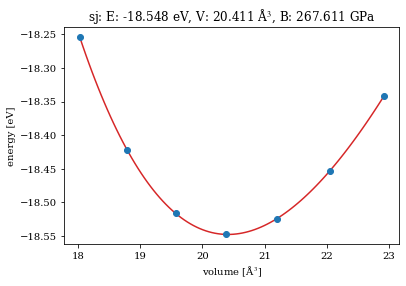

In [36]:
#EoS with ase
import numpy as np
from ase.io import read
from ase.units import kJ
from ase.eos import EquationOfState

configs = []
for i, a in enumerate(np.linspace(5,6,7)):
    configs.append(read('sampleoutputs/OUTCAR_eos'+str(i)))  # read 7 configurations
# Extract volumes and energies:
volumes = [ag.get_volume() for ag in configs]
energies = [ag.get_potential_energy() for ag in configs]

eos = EquationOfState(volumes, energies, eos = 'sjeos')
v0, e0, B = eos.fit()
print('B = {:.0f} GPa,  a = {:.2f} A'.format(B / kJ * 1.0e24, (v0*4)**(1/3)))
eos.plot('TiC_eos.pdf')


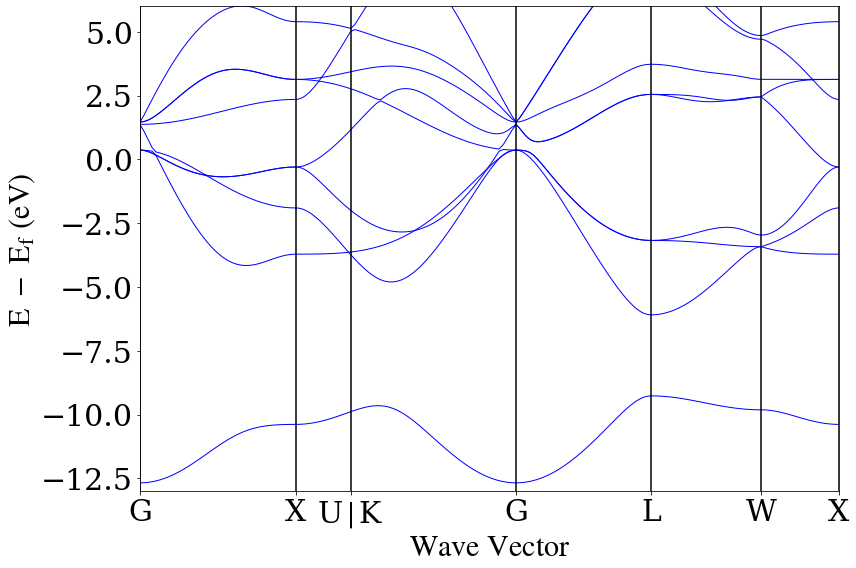

In [33]:
#Plot band structure with pymatgen
%matplotlib inline
from pymatgen.io.vasp import Vasprun, BSVasprun
from pymatgen.electronic_structure.plotter import BSPlotter

v = BSVasprun("sampleoutputs/vasprun_band.xml")
bs = v.get_band_structure(kpoints_filename="sampleinputs/KPOINTS_band",line_mode=True)
plt = BSPlotter(bs,)
ax = plt.get_plot(vbm_cbm_marker=True, ylim = (-13,6))
ax.savefig('band.pdf')


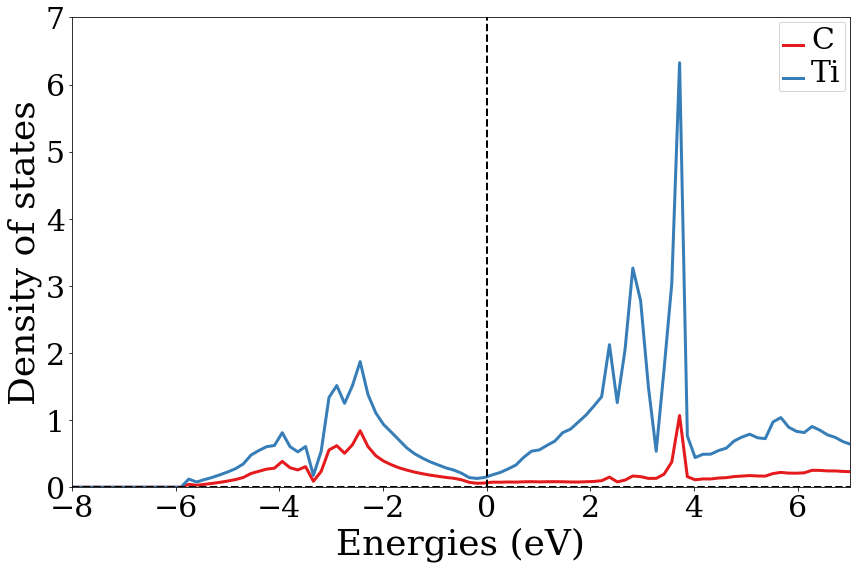

In [36]:
#Plot PDOS with pymatgen
%matplotlib inline
from pymatgen.io.vasp import Vasprun
from pymatgen.electronic_structure.plotter import DosPlotter

v = Vasprun('sampleoutputs/vasprun_dos.xml')
cdos = v.complete_dos
element_dos1 = cdos.get_element_dos()
# element_dos1 = cdos.get_element_spd_dos('Ti')
# element_dos2 = cdos.get_element_spd_dos('C')

plotter = DosPlotter()
plotter.add_dos_dict(element_dos1)
plotter.show(xlim=[-8, 7], ylim=[0, 7])



In [17]:
#plot phonon density of states using pymatgen and phonopy
import pymatgen as pmg
from pymatgen.io.vasp.outputs import Vasprun

from phonopy import Phonopy # install with sudo pip3 install phonopy
from phonopy.structure.atoms import Atoms as PhonopyAtoms
from phonopy.units import VaspToTHz
%matplotlib inline
Si_primitive = PhonopyAtoms(symbols=['Ti', 'C'],
                            scaled_positions=[(0, 0, 0), (0.5, 0.5, 0.5)], 
                            cell=[[0.,      2.167825, 2.167825],
                                  [2.167825, 0.,      2.167825],
                                  [2.167825, 2.167825, 0.     ]])

# supercell size
scell = [[1,0,0],[0,1,0],[0,0,1]]

vrun = Vasprun('sampleoutputs/vasprun_freq.xml')

phonon = Phonopy(Si_primitive, scell,factor=VaspToTHz)

# negative sign to ensure consistency with phonopy convention
phonon.set_force_constants(-vrun.force_constants)
mesh = [48, 48, 48]
phonon.set_mesh(mesh)

phonon.set_total_DOS()
phonon.plot_total_DOS().show()

/home/anton/.local/lib/python3.6/site-packages/pymatgen/io/vasp/inputs.py:1859: BadPotcarWarning: POTCAR with symbol Ti has metadata that does not match                          any VASP POTCAR known to pymatgen. The data in this                          POTCAR is known to match the following functionals:                          ['PBE']
  BadPotcarWarning)
/home/anton/.local/lib/python3.6/site-packages/pymatgen/io/vasp/inputs.py:1859: BadPotcarWarning: POTCAR with symbol C has metadata that does not match                          any VASP POTCAR known to pymatgen. The data in this                          POTCAR is known to match the following functionals:                          ['PBE']
  BadPotcarWarning)
